In [ ]:
# CREATE SYNTHETIC DATA

import pandas as pd
import numpy as np

# Create a template DataFrame with the same structure as your original data
# Replace this with the actual column names and types from your original data

# Paths
#r'C:/Users/gusta/Documents/KTH/TriOptima/trioptima/trioptima/'
#'/Users/elliotlindestam/Documents/Skola/Indek icloud/trioptima/'

your_path = r'C:/Users/gusta/Documents/KTH/TriOptima/trioptima/trioptima/'
file_path = your_path + '2.Cleaned/Modified_IRS_All_Train_VF_Cleaned.csv'

cols_to_modify = [
"leg1FixedRate",
"leg1NotionalAmount"]

data = pd.read_csv(file_path)

# Number of duplicates
num_duplicates = 1

# List to store duplicated rows
synthetic_data = []

# Loop through each row and create duplicates with noise
i = 0
for index, row in data.iterrows():
    for _ in range(num_duplicates):
        new_row = row.copy()
        i += 1

        for col_to_modify in cols_to_modify:
            # Create a new row by adding noise to the data  
            noise = np.random.normal(0, abs(new_row[col_to_modify]) * 0.05)
            if pd.isna(noise):
                pass
            else:
                if col_to_modify == 'leg1NotionalAmount':
                    new_row[col_to_modify] += noise
                    new_row['leg2NotionalAmount'] += noise
                else:
                    new_row[col_to_modify] + noise
            
        synthetic_data.append(new_row)


# Concatenate the original data with the synthetic data
synthetic_data = pd.concat([data, pd.DataFrame(synthetic_data)], ignore_index=True)
synthetic_data['leg1NotionalAmount'] = synthetic_data['leg1NotionalAmount'].astype(int)

# Save the synthetic data to a new CSV file
synthetic_data.to_csv(your_path + "2.Cleaned/synthetic_data_cleaned.csv", index=False)


Synthetic cash risk

In [ ]:
# 1. Imports
import os
import pandas as pd
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# 2. Configuration
train_folder_path = your_path + '6.Active Data/Train Model Data/'
test_folder_path = your_path + '6.Active Data/Test Data/'

# 3. Functions
def convert_to_usd(row,exchange_rates):
    return row['leg1NotionalAmount'] * exchange_rates.get(row['leg1NotionalCurrency'], 1)

def calculate_cashflows(row, period, freq):
    cashflows = []
    start_date = row['effectiveDate']
    end_date = row['expirationDate']
    
    if row[period] == 'MNTH':
        delta = relativedelta(months=row[freq])
    elif row[period] == 'YEAR':
        delta = relativedelta(years=row[freq])
    elif row[period] == 'DAIL':
        delta = timedelta(days=row[freq])
    elif row[period] == 'QTR':
        delta = relativedelta(months=3)
    else:
        raise ValueError(f"Unknown frequency period: {row[period]}")
    
    while start_date <= end_date:
        cashflows.append(start_date)
        start_date += delta

    return cashflows

def convert_to_years(value):
    
    if "M" in value:
        return int(str(value)[:-1])/12
    elif "Y" in value:
        return int(str(value)[:-1])
    else:
        return 0

def floating_rate(years_to_payout, float_rates_df, bump):
    differences = float_rates_df['Tenor'].sub(years_to_payout).abs()
    nearest_index = differences.idxmin()
    return (float_rates_df.loc[nearest_index, 'Rate'] + bump)/ 100

def calculate_discounted_cashflow(row, rate_type, bump, float_rates_df_list):
    total_discounted_cashflow = 0
    
    # CHECK
    discounted_cashflow_list = []
    cashflow_list = []
    factors = []
    pr_list = []
    discount_rate = []

    ibor = row['leg2UnderlierID']
    for item in float_rates_df_list:
        if item[0] == ibor:
            float_rates_df = item[1]
            break 
    
    for date in row['cashflow_dates']:

        if len(cashflow_list) == 0:

            time_difference = (date - datetime.now()).days / 365.0
            tenor = time_difference ### MONTHS IS TO MATCH THE INDEX IN OUR IBOR FILE
            float_rate = floating_rate(tenor,float_rates_df, bump)
            factor = (1 + float_rate)**time_difference
            factors.append(factor)
            discount_rate.append([tenor,1/ factor])

            if rate_type == 'float':
                payout_rate = float_rate
                cashflow = row['leg1NotionalAmount'] * payout_rate
                
            if rate_type == 'fixed':
                payout_rate = row['leg1FixedRate']
                cashflow = row['leg1NotionalAmount'] * payout_rate
                
            discounted_cashflow = cashflow / factor
        
        else:
            time_difference = ((date-row['cashflow_dates'][len(factors)-1])).days/365
            tenor = (date - datetime.now()).days / 365
            float_rate = floating_rate(tenor,float_rates_df,bump)
            prev_factor = factors[-1]
            factor = prev_factor * (1 + payout_rate) ** time_difference
            factors.append(factor)
            discount_rate.append([tenor,1/ factor])
            if rate_type == 'float':    
                payout_rate = float_rate
                cashflow = row['leg1NotionalAmount'] * payout_rate
            
            if rate_type == 'fixed':
                payout_rate = row['leg1FixedRate']
                cashflow = row['leg1NotionalAmount'] * row['leg1FixedRate']
                
            discounted_cashflow = cashflow / factor
        pr_list.append(payout_rate)
        total_discounted_cashflow += discounted_cashflow
        
        # CHECK
        cashflow_list.append(cashflow)
        discounted_cashflow_list.append(discounted_cashflow)
    
    # CHECK 
    #print('Total discounted CF '+rate_type+': '+str(total_discounted_cashflow))
    #print(rate_type + ' cashflow list ' + str((cashflow_list)))
    #print(rate_type + ' '+ibor+' discount rates ' + str((discount_rate)))
    #print('\n')
    
    #print(rate_type + ' discounted cashflow list ' + str(discounted_cashflow_list) )
    #print(rate_type + ' discount factors ' + str((factors)))
    #print('\n')
    return total_discounted_cashflow

def fx_rates (your_path):
    exchange_rates_df = pd.read_csv(your_path + '7.IBOR/exchange_rates.csv')
    exchange_rates = dict(zip(exchange_rates_df['Currency'], exchange_rates_df['Rate_to_USD']))
    return exchange_rates

def fl_df (your_path, ibor):
    ibor_df = pd.read_csv(your_path + '7.IBOR/' + ibor + '.csv')
    ibor_df['Tenor'] = ibor_df['Tenor'].apply(convert_to_years) ## MAKE SURE ALL FILES ARE CODED THE SAME
    float_rates_df = ibor_df[['Tenor', 'Rate']].copy()
    return float_rates_df

def main (folder_path, your_path, bump):
    # 4. Data Loading
    # Load trade data
    
    data = pd.read_csv(your_path + "2.Cleaned/synthetic_data_cleaned.csv")

    # Load exchange rates
    fx_df = fx_rates(your_path)
   
    # 5. Data Transformation and Filtering
    filtered_data = data[
        (data['leg1NotionalCurrency'].isin(['EUR', 'USD', 'GBP', 'AUD', 'CAD', 'NZD'])) & 
        (data['leg1UnderlyingAssetOrContractType'].isin(['Fixed-Floating', 'OIS']))
    ]
    df = pd.DataFrame(filtered_data)


    df['effectiveDate'] = pd.to_datetime(df['effectiveDate'])
    df['expirationDate'] = pd.to_datetime(df['expirationDate'])

    df['cashflow_dates'] = df.apply(
        lambda row: 
            calculate_cashflows(row, 'leg1FixedRatePaymentFrequencyPeriod', 'leg1FixedRatePaymentFrequencyMultiplier') 
            if row['leg1UnderlyingAssetOrContractType'] == 'Fixed-Floating' 
            else (calculate_cashflows(row, 'leg2UnderlierTenorPeriod', 'leg2UnderlierTenorMultiplier') 
                if row['leg1UnderlyingAssetOrContractType'] == 'OIS' 
                else None), 
        axis=1)

    # 6. Based on data - Load relevant IBORs to be used as float_rates in operations
    float_rates_df_list = []
    for ibor in df['leg2UnderlierID'].unique():
        float_rates_df_list.append([ibor,fl_df(your_path,ibor)])
        
    # 7. Main Operations
    df['leg1NotionalAmountUSD'] = df.apply(lambda row: convert_to_usd(row, fx_df), axis=1)
    df['MtM_leg1'] = df.apply(lambda row: calculate_discounted_cashflow(row, 'fixed', 0, float_rates_df_list), axis=1)
    df['MtM_leg2'] = df.apply(lambda row: calculate_discounted_cashflow(row, 'float', 0, float_rates_df_list), axis=1)
    df['MtM_leg2_bumped'] = df.apply(lambda row: calculate_discounted_cashflow(row, 'float', bump/100, float_rates_df_list), axis=1)
    df['total_delta'] = (df['MtM_leg2'] - df['MtM_leg2_bumped']).abs()
    
    df = df[df['MtM_leg1'] != 0]

    # 8. Export/Output
    df.drop(columns=['cashflow_dates', 'MtM_leg2_bumped'], inplace=True)
    df.to_csv(your_path + '3.Cash_Risk/synthetic_data_Cash_Risk.csv', index=False)

# folder path, your path, bump (basis points, used to measure risk), outlier (used to create outliers in test data)
main(train_folder_path, your_path,bump=1)
#main(test_folder_path, your_path,bump=1)



C:\Users\gusta\AppData\Local\Temp\ipykernel_18488\738767939.py:139: DtypeWarning: Columns (1,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(your_path + "2.Cleaned/synthetic_data_cleaned.csv")


Synthetic processing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import joblib
import os

# Load the data
data = pd.read_csv(your_path + '3.Cash_Risk/synthetic_data_Cash_Risk.csv')

# Step 1: Handle Missing Data
data_filled = data.fillna(0)

# Step 2: Extract Information from DateTime Columns
datetime_columns = ['effectiveDate', 'executionDateTime', 'expirationDate'] # ['effectiveDate', 'expirationDate', 'eventDateTime',] # 

def extract_date_features(df, column):
    df[column] = pd.to_datetime(df[column], errors='coerce')
    df[column + '_year'] = df[column].dt.year
    df[column + '_month'] = df[column].dt.month
    df[column + '_day'] = df[column].dt.day
    df[column + '_hour'] = df[column].dt.hour
    df[column + '_minute'] = df[column].dt.minute
    df[column + '_second'] = df[column].dt.second
    df[column + '_weekday'] = df[column].dt.weekday
    # Drop the original datetime column
    df = df.drop(column, axis=1)
    return df

for col in datetime_columns:
    data_filled = extract_date_features(data_filled, col)

original_dtypes = data.dtypes.to_dict()

# Convert boolean columns to binary (1/0) before one-hot encoding other categorical columns
data_filled = data_filled*1

def compare_item(row,leg1,leg2):
    return 1 if row[leg1] == row[leg2] else 0

cur = data_filled.apply(lambda row: compare_item(row, 'leg1NotionalCurrency','leg2NotionalCurrency'), axis=1)
nom = data_filled.apply(lambda row: compare_item(row, 'leg1NotionalAmount','leg2NotionalAmount'), axis=1)

# Step 3: Encode Categorical Variables
categorical_columns = data_filled.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col not in datetime_columns]
data_encoded = pd.get_dummies(data_filled, columns=categorical_columns, drop_first=True)

# Step 3.5: Identify and Drop Single-Value Columns
single_value_columns = data_encoded.columns[data_encoded.nunique() == 1].tolist()

# Optionally print these columns and their unique values
print("Columns with a single unique value: ", single_value_columns)

# Drop the single-value columns
data_encoded = data_encoded.drop(columns=single_value_columns)
data_encoded['CurrencyIV'] = cur
data_encoded['NominalIV'] = nom
#data_encoded = data_encoded.fillna(0)
# Define numerical_columns here, after all column dropping and adding has occurred

print(data_encoded.columns)
# Create interaction variable

numerical_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Check for NaN or infinite values in numerical columns before scaling
nan_inf_columns = data_encoded[numerical_columns].columns[data_encoded[numerical_columns].isna().any() | np.isinf(data_encoded[numerical_columns]).any()].tolist()
print("Columns with NaN or infinite values before scaling: ", nan_inf_columns)

# Step 4: Scale/Normalize Data
numerical_columns = data_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
scaler = RobustScaler()
data_encoded[numerical_columns] = scaler.fit_transform(data_encoded[numerical_columns])

# Save the scaler for future use
scaler_filename = 'robust_scaler.pkl'
joblib.dump(scaler, scaler_filename)

# Preprocessed data is now stored in `data_encoded`, and the scaler is saved as `robust_scaler.pkl`
# Save the processed data to a CSV file in this environment
data_encoded.to_csv(your_path + '4.Scaled/synthetic_data_Scaled.csv', index=False)

train_encoded_columns = data_encoded.columns


C:\Users\gusta\AppData\Local\Temp\ipykernel_18488\3013598515.py:8: DtypeWarning: Columns (1,22) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(your_path + '3.Cash_Risk/synthetic_data_Cash_Risk.csv')


Columns with a single unique value:  ['customBasketIndicator', 'packageIndicator', 'postPricedSwapIndicator', 'CurrencyIV', 'NominalIV', 'effectiveDate_hour', 'effectiveDate_minute', 'effectiveDate_second', 'executionDateTime_year', 'executionDateTime_month', 'executionDateTime_day', 'executionDateTime_hour', 'executionDateTime_minute', 'executionDateTime_second', 'executionDateTime_weekday', 'expirationDate_hour', 'expirationDate_minute', 'expirationDate_second']
Index(['leg1NotionalAmount', 'leg2NotionalAmount', 'leg1FixedRate',
       'leg1FixedRatePaymentFrequencyMultiplier',
       'leg2UnderlierTenorMultiplier', 'leg1NotionalAmountUSD', 'MtM_leg1',
       'MtM_leg2', 'total_delta', 'effectiveDate_year', 'effectiveDate_month',
       'effectiveDate_day', 'effectiveDate_weekday', 'expirationDate_year',
       'expirationDate_month', 'expirationDate_day', 'expirationDate_weekday',
       'cleared_Y', 'event_Allocation', 'event_Amendment',
       'event_BLENDING_REMNANT', 'event_Clea

Autoencoder

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras import regularizers

# Constants and Configurations
LAYER_OPTIONS = [1]#[1,2,5,10]
NEURON_OPTIONS = [1000]#[500, 1000]
DECREASING_NEURONS = 50
MIN_NEURONS = 50
ENCODER_ACTIVATION_FUNCTIONS = ['sigmoid'] # ['relu', 'leaky_relu', 'tanh', 'sigmoid', 'softplus', 'elu', 'swish', 'gelu','linear']
DECODER_ACTIVATION_FUNCTIONS = ['relu'] # ['relu', 'leaky_relu', 'tanh', 'sigmoid', 'softplus', 'elu', 'swish', 'gelu','linear']
L2_REGULARIZATION = 0.01  # L2 Regularization factor
DROPOUT_RATE = 0.5  # Dropout rate

INITIAL_VAL_LOSS = float('inf')  # Set initial value to infinity

def load_preprocessed_data(folder_path):
    # Load the data
    data = pd.read_csv(folder_path + '4.Scaled/synthetic_data_Scaled.csv')

    return data

def build_autoencoder(input_dim, starting_neurons, num_layers, decreasing_neurons, min_neurons, encoder_activation_fn, decoder_activation_fn):
    current_num_neurons = starting_neurons
    input_layer = layers.Input(shape=(input_dim,))
    encoder_layer = layers.Dense(current_num_neurons, activation=encoder_activation_fn,
                                 kernel_regularizer=regularizers.l2(L2_REGULARIZATION))(input_layer)
    encoder_layer = layers.Dropout(DROPOUT_RATE)(encoder_layer)  # Dropout layer after the input
    nodes_per_layer = [current_num_neurons]

    for _ in range(1, num_layers):
        current_num_neurons = max(min_neurons, current_num_neurons - decreasing_neurons)
        encoder_layer = layers.Dense(current_num_neurons, activation=encoder_activation_fn,
                                     kernel_regularizer=regularizers.l2(L2_REGULARIZATION))(encoder_layer)
        encoder_layer = layers.Dropout(DROPOUT_RATE)(encoder_layer)  # Dropout layer after each dense layer
        nodes_per_layer.append(current_num_neurons)

    decoder_layer = layers.Dense(input_dim, activation=decoder_activation_fn)(encoder_layer)

    model = models.Model(inputs=input_layer, outputs=decoder_layer)
    return model, nodes_per_layer


def main():
    data_preprocessed = load_preprocessed_data(your_path)
    data_preprocessed = data_preprocessed.values.astype(np.float32)

    # Ensure data is in expected format
    #assert data_preprocessed.map(np.isreal).all().all(), "Non-numeric data found"
    #assert not data_preprocessed.isnull().any().any(), "NaN values found"

    input_dim = data_preprocessed.shape[1]
    best_num_layers = None
    best_num_neurons = None
    best_weights = None
    best_val_loss = INITIAL_VAL_LOSS

    best_encoder_activation_fn = None
    best_decoder_activation_fn = None

    for encoder_activation_fn in ENCODER_ACTIVATION_FUNCTIONS:
        for decoder_activation_fn in DECODER_ACTIVATION_FUNCTIONS:
            for num_neurons in NEURON_OPTIONS:
                for num_layers in LAYER_OPTIONS:
                    K.clear_session()

                    temp_autoencoder, _ = build_autoencoder(input_dim, num_neurons, num_layers, DECREASING_NEURONS, MIN_NEURONS, encoder_activation_fn, decoder_activation_fn)
                    
                    temp_autoencoder.compile(optimizer='adam', loss='mean_squared_error')
                    
                    # Define early stopping callback
                    early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

                    history = temp_autoencoder.fit(
                        data_preprocessed, data_preprocessed,
                        epochs=500, 
                        batch_size=32,
                        shuffle=True,
                        validation_split=0.1,
                        callbacks=[early_stopping_callback]  # Add early stopping callback
                    )

                    final_val_loss = history.history['val_loss'][-1]
                    if final_val_loss < best_val_loss:
                        best_val_loss = final_val_loss
                        best_num_layers = num_layers
                        best_num_neurons = num_neurons
                        best_weights = temp_autoencoder.get_weights()
                        best_encoder_activation_fn = encoder_activation_fn
                        best_decoder_activation_fn = decoder_activation_fn

    # Construct best model
    autoencoder, nodes_per_layer = build_autoencoder(
        input_dim, best_num_neurons, best_num_layers, DECREASING_NEURONS, MIN_NEURONS,
        best_encoder_activation_fn, best_decoder_activation_fn
    )
    autoencoder.set_weights(best_weights)

    # Display the configuration of the best model
    print(f"Best Model Configuration:")
    print(f"Number of Layers: {best_num_layers}")
    print(f"Number of Neurons per Layer: {nodes_per_layer}")
    print(f"Encoder Activation Function: {best_encoder_activation_fn}")
    print(f"Decoder Activation Function: {best_decoder_activation_fn}")

    return autoencoder


if __name__ == "__main__":
    autoencoder = main()

Epoch 1/500
1132/1132 [==============================] - 3s 2ms/step - loss: 73308.7344 - val_loss: 53205.5547
Epoch 2/500
1132/1132 [==============================] - 2s 2ms/step - loss: 38553.6875 - val_loss: 26287.0723
Epoch 3/500
1132/1132 [==============================] - 2s 2ms/step - loss: 17620.4258 - val_loss: 10565.1865
Epoch 4/500
1132/1132 [==============================] - 2s 2ms/step - loss: 6245.1182 - val_loss: 2920.0295
Epoch 5/500
1132/1132 [==============================] - 2s 2ms/step - loss: 1507.8071 - val_loss: 414.8914
Epoch 6/500
1132/1132 [==============================] - 2s 2ms/step - loss: 324.7729 - val_loss: 23.5693
Epoch 7/500
1132/1132 [==============================] - 2s 2ms/step - loss: 211.1639 - val_loss: 11.8938
Epoch 8/500
1132/1132 [==============================] - 2s 2ms/step - loss: 216.1960 - val_loss: 11.8688
Epoch 9/500
1132/1132 [==============================] - 2s 2ms/step - loss: 212.3997 - val_loss: 4.2882
Epoch 10/500
1132/1132 [===

In [ ]:
print(your_path)

test_folder_path = your_path + '4.Scaled/IRS_All_Test_Notional_Scaled.csv'
train_folder_path = your_path + '4.Scaled/synthetic_data_Scaled.csv'

train_data_preprocessed = pd.read_csv(train_folder_path)
test_data_preprocessed = pd.read_csv(test_folder_path)
# Check to make sure the data is in expected format
def mse_calc (data_preprocessed):
    try:
        data_preprocessed = data_preprocessed.values.astype(np.float32)
    except ValueError as e:
        print(f"ValueError: {e}")

    # Check to make sure the data is in expected format
    #assert data_preprocessed.map(np.isreal).all().all(), "Non-numeric data found"
    #assert not data_preprocessed.isnull().any().any(), "NaN values found"

    # Obtain the reconstructed data
    predictions = autoencoder.predict(data_preprocessed)

    # Measure the reconstruction error
    mse = np.mean(np.power(data_preprocessed - predictions, 2), axis=1)
    return mse

mse_train_df = pd.DataFrame({'reconstruction_error':mse_calc(train_data_preprocessed)})
mse_test_df = pd.DataFrame({'reconstruction_error':mse_calc(test_data_preprocessed)})

# Convert mse to a DataFrame for easier handling


# Display basic statistics of the error
print(mse_train_df.describe())
print(mse_test_df.describe())


C:/Users/gusta/Documents/KTH/TriOptima/trioptima/trioptima/
2/2 [==============================] - 0s 2ms/step
       reconstruction_error
count          40244.000000
mean               3.493922
std                4.879215
min                0.099264
25%                1.243603
50%                2.365194
75%                4.150873
max              239.941360
       reconstruction_error
count          3.600000e+01
mean           1.630078e+05
std            8.970420e+05
min            6.235389e-01
25%            2.856316e+00
50%            4.974209e+00
75%            5.679698e+01
max            5.379045e+06


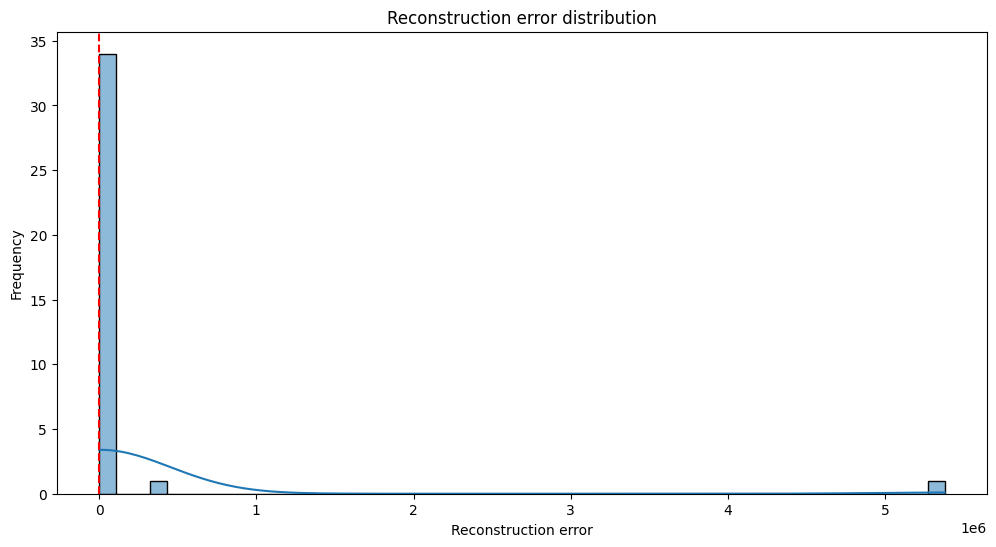

Anomaly threshold: 4.7490668296813965


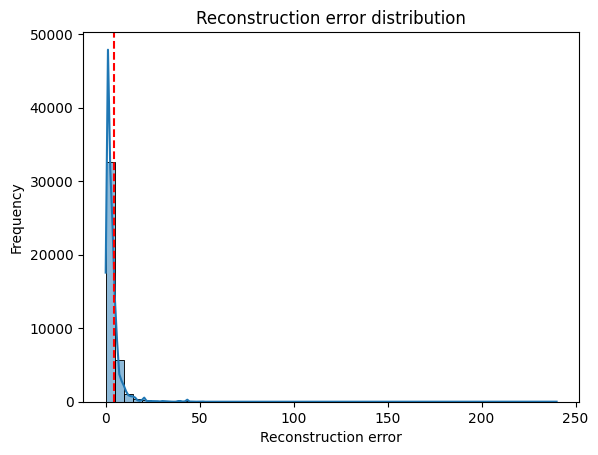

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(mse_test_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')


threshold = np.percentile(mse_train_df['reconstruction_error'], 80)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 
print(f"Anomaly threshold: {threshold}")

sns.histplot(mse_train_df['reconstruction_error'], bins=50, kde=True)
plt.title('Reconstruction error distribution')
plt.xlabel('Reconstruction error')
plt.ylabel('Frequency')
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
plt.show() 



In [ ]:
import pandas as pd
import numpy as np

t_data_path = your_path + '3.Cash_Risk/' + 'IRS_All_Test_Notional' +'_Cash_Risk.csv' # THIS IS THE ORIGINAL TEST DATA 
t_data_scaled_path = your_path + '4.Scaled/' + 'IRS_All_Test_Notional' + '_Scaled.csv' # THIS IS THE SCALED TEST DATA

# Load new trade data from CSV (both processed and original)
t_data_scaled = pd.read_csv(t_data_scaled_path)
t_data = pd.read_csv(t_data_path)

# Determine whether each trade is an outlier or not
outlier_indices = mse_test_df[mse_test_df['reconstruction_error'] > threshold].index

# Filter the outlier trades from the original data using the outlier indices
outlier_trades_original = t_data.iloc[outlier_indices]

# Save the outlier trades to a CSV file in the original format
outlier_file_path = your_path + '5.Outliers/' + 'Outlier_IRS_test.csv'
outlier_trades_original.to_csv(outlier_file_path, index=False)

print('Number of outlier trades: '+str(len(outlier_trades_original)))
print('See trades in directory: '+outlier_file_path)

Number of outlier trades: 22
See trades in directory: C:/Users/gusta/Documents/KTH/TriOptima/trioptima/trioptima/5.Outliers/Outlier_IRS_test.csv
